# Project 2: Reproducibility in Natural Language Processing



### Read Data

In [5]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-dark') 

In [29]:
sou = pd.read_csv("data/SOTU.csv")

In [11]:
import spacy
from tqdm import tqdm
from collections import Counter

nlp = spacy.load("en_core_web_sm")

## Part 3: Advanced Text Processing - LDA and BERTopic Topic Modeling (20 pts)

**Resources:**
- LDA:
    - https://medium.com/sayahfares19/text-analysis-topic-modelling-with-spacy-gensim-4cd92ef06e06 
    - https://www.kaggle.com/code/faressayah/text-analysis-topic-modeling-with-spacy-gensim#%F0%9F%93%9A-Topic-Modeling (code for previous post)
    - https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf/ 
- BERTopic:
    - https://maartengr.github.io/BERTopic/getting_started/visualization/visualize_documents.html#visualize-documents-with-plotly 
    - https://maartengr.github.io/BERTopic/getting_started/visualization/visualize_topics.html 


In [30]:
from spacy import displacy
from bertopic import BERTopic
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis
import pyLDAvis.gensim_models

### LDA

- Train an LDA model with 18 topics
- Output the top 10 words for each topic. 
- Output the topic distribution for the first speech
- Make a visualization

You may use the next two cells to process the data.

In [12]:
def preprocess_text(text):
    doc = nlp(text)
    return [token.lemma_.lower() for token in doc if not token.is_stop and not
            token.is_punct and not token.is_space and len(token.lemma_) > 3]

In [13]:
# Process all texts - note this takes ~ 5 minutes to run
processed_docs = sou['Text'].apply(preprocess_text)

To train an LDA model, use the LdaModel function that we imported a couple of cells back. The last resource linked under the LDA section is especially useful for walking through the steps we have below. *Note: one of the arguments to the LdaModel function is `random_state` which specifies the random seed for reproducibility. Please set yours to 42. Further, the last resource provided uses `LdaMulticore` which is essentially a parallelizable version of our function `LdaModel`. Use `LdaModel` instead, but the usage will be similar, except you can ignore the `iterations` and `workers` arguments..*.

In [16]:
# Build dictionary from processed_docs, which is a list of tokens extracted from our speeches
dictionary = Dictionary(processed_docs)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

In [17]:
# train LDA model with 18 topics
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
model_LDA = LdaModel(corpus=corpus, id2word=dictionary, num_topics=18, random_state=42)

In [18]:
# print the top 10 words for each topic
model_LDA.print_topics()

[(0,
  '0.007*"mexico" + 0.005*"spain" + 0.004*"island" + 0.004*"minister" + 0.004*"convention" + 0.004*"port" + 0.004*"article" + 0.004*"program" + 0.003*"june" + 0.003*"indians"'),
 (1,
  '0.005*"program" + 0.004*"today" + 0.004*"cent" + 0.004*"note" + 0.004*"americans" + 0.004*"tariff" + 0.004*"island" + 0.004*"budget" + 0.004*"indians" + 0.003*"indian"'),
 (2,
  '0.015*"americans" + 0.011*"program" + 0.009*"tonight" + 0.008*"billion" + 0.008*"challenge" + 0.007*"budget" + 0.006*"fight" + 0.005*"percent" + 0.005*"thank" + 0.005*"worker"'),
 (3,
  '0.005*"convention" + 0.004*"cent" + 0.004*"minister" + 0.004*"note" + 0.004*"june" + 0.004*"method" + 0.004*"actual" + 0.003*"tariff" + 0.003*"railroad" + 0.003*"port"'),
 (4,
  '0.005*"americans" + 0.005*"mexico" + 0.004*"convention" + 0.004*"gold" + 0.004*"june" + 0.004*"spain" + 0.003*"island" + 0.003*"british" + 0.003*"indian" + 0.003*"currency"'),
 (5,
  '0.010*"americans" + 0.008*"tonight" + 0.007*"program" + 0.006*"today" + 0.004*"b

In [20]:
# print the topic distribution for the first speech
model_LDA[corpus][0]

[(2, np.float32(0.9988718))]

In [21]:
# make a visualization using pyLDAvis
pyLDAvis.enable_notebook()
lda_display = pyLDAvis.gensim_models.prepare(model_LDA, corpus, dictionary)
pyLDAvis.display(lda_display)

### BERTopic

- Train a BERTopic model with a `min_topic_size` of 3 *Hint: use `BERTopic` to instantiate the model and specify `min_topic_size` in here. Actually fit the model using `fit_transform`, which `docs` passed into this.*
- Output the top 10 words for each topic. 
- Output the topic distribution for the first speech
- Make a visualization of the topics (see topic_model.visualize_topics())

In [22]:
docs = sou['Text'].to_list()

In [23]:
# train the model - this takes about 30 seconds
model = BERTopic(min_topic_size=3, verbose=True)
topics, probs = model.fit_transform(docs)

2025-11-21 01:10:53,442 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:11<00:00,  1.38s/it]
2025-11-21 01:11:10,484 - BERTopic - Embedding - Completed ✓
2025-11-21 01:11:10,485 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-21 01:11:21,598 - BERTopic - Dimensionality - Completed ✓
2025-11-21 01:11:21,600 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-21 01:11:21,615 - BERTopic - Cluster - Completed ✓
2025-11-21 01:11:21,658 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-21 01:11:23,300 - BERTopic - Representation - Completed ✓


In [24]:
# remove stop words from the topics (Hint: use CountVectorizer and then .update_topics on topic_model)
vector = CountVectorizer(stop_words='english')
model.update_topics(docs, vectorizer_model=vector)

In [26]:
# output the top 10 words for each topic - hint see get_topic_info
model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,61,-1_states_government_united_congress,"[states, government, united, congress, year, p...",[\nTo the Congress of the United States:\nYour...
1,0,34,0_america_americans_people_new,"[america, americans, people, new, american, to...","[\nMr. President, Mr. Speaker, Members of the ..."
2,1,25,1_world_people_years_new,"[world, people, years, new, american, america,...","[\nMr. Speaker, Mr. President, my colleagues i..."
3,2,14,2_states_united_government_department,"[states, united, government, department, great...",[\nFellow-Citizens of the Senate and House of ...
4,3,13,3_states_government_united_public,"[states, government, united, public, mexico, c...",[\nFellow-Citizens of the Senate and House of ...
5,4,11,4_world_peace_nations_soviet,"[world, peace, nations, soviet, nation, econom...","[\nMr. President, Mr. Speaker, Members of the ..."
6,5,11,5_government_law_great_work,"[government, law, great, work, public, busines...",[\nTo the Senate and House of Representatives:...
7,6,9,6_government_states_law_united,"[government, states, law, united, year, gold, ...",[\nTo the Senate and House of Representatives:...
8,7,9,7_states_government_united_constitution,"[states, government, united, constitution, con...",[\nFellow-Citizens of the Senate and House of ...
9,8,8,8_world_government_free_great,"[world, government, free, great, states, peopl...",[\nGENTLEMEN OF THE CONGRESS:\nThe year that h...


In [27]:
# output the topic distribution for the first speech
# hint: check out approximate_distribution() and visualize_distribution()
topic_distr, _ = model.approximate_distribution(docs, min_similarity=0)
model.visualize_distribution(topic_distr[0])

100%|██████████| 1/1 [00:15<00:00, 15.75s/it]


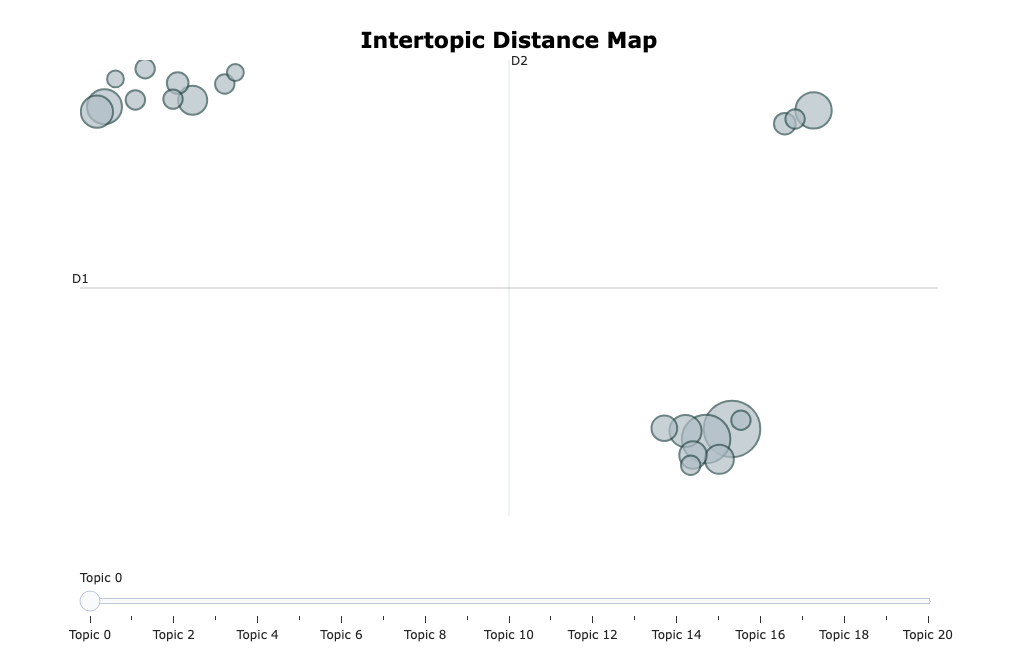

In [28]:
# run this cell to visualize the topics
model.visualize_topics()